In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def tidy_split(df, column, sep=',', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value)
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df




In [26]:
# Read titles information
titles_info = pd.read_csv('/Users/Apple/Downloads/title.basics.tsv', delimiter = '\t', low_memory=False)
titles = titles_info.drop(columns = ['originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres'], axis = 1)

#Read names information
names_info = pd.read_csv('/Users/Apple/Downloads/name.basics.tsv', delimiter = '\t', low_memory=False)
names_info = names_info.drop(columns = ['birthYear', 'deathYear', 'primaryProfession', 'knownForTitles'])

# Read ratings information
ratings_info = pd.read_csv('/Users/Apple/Downloads/title.ratings.tsv.gz', delimiter='\t', low_memory = False)


# Directors information
# Drop 'writer' column and merge with ratings info.
director_info = pd.read_csv('/Users/Apple/Downloads/title.crew.tsv', delimiter ='\t')
directors_info = director_info.drop(columns = ['writers'], axis =1)
directors_info = directors_info.merge(ratings_info, on = 'tconst', how = 'outer')

# Further clean by dropping all rows where 'director' information is missing and numVotes > 100,000
directors_info = directors_info.dropna(subset = ['directors'])
directors_info = directors_info[directors_info['numVotes']>100000]

# Retrieve only those titles that are movies and obtain their unique constants
titles = titles[titles['titleType']=='movie']
movie_titles = titles['tconst']

# Retrieve the director information only for titles that are movies
directors_info = directors_info[directors_info['tconst'].isin(movie_titles)]

# Duplicate rating information for titles with multiple directors
directors_info = tidy_split(directors_info, 'directors', ',')


KeyboardInterrupt: 

In [11]:
def weighted_rating(df):
    """
    Compute the score for a given director as:
    sum over all movies (number of votes * average rating)/ # of movies made by the director

    Params
    -------
    df : Groupby object that contains the group information for the current director group
    numVotes : df param that contains the number of votes for all the movies
    averageRating : df param that contains average rating for all the movies

    Returns
    -------
    Float32
    Returns the score of the director for the current gro
    """
    a = (df.numVotes* df.averageRating)
    return a.sum()/len(df.directors)

# Group by director name and compute score for each director
scores = []
names = []
groups = directors_info.groupby('directors')
for name, group in groups:
    names.append(name)
    scores.append(weighted_rating(group))
    
# print names, scores


['nm0000005', 'nm0000033', 'nm0000037', 'nm0000040', 'nm0000041', 'nm0000080', 'nm0000092', 'nm0000095', 'nm0000108', 'nm0000110', 'nm0000116', 'nm0000118', 'nm0000122', 'nm0000123', 'nm0000126', 'nm0000127', 'nm0000134', 'nm0000142', 'nm0000154', 'nm0000165', 'nm0000180', 'nm0000184', 'nm0000186', 'nm0000217', 'nm0000229', 'nm0000230', 'nm0000231', 'nm0000233', 'nm0000247', 'nm0000255', 'nm0000264', 'nm0000269', 'nm0000277', 'nm0000316', 'nm0000318', 'nm0000338', 'nm0000341', 'nm0000343', 'nm0000361', 'nm0000362', 'nm0000386', 'nm0000399', 'nm0000408', 'nm0000416', 'nm0000431', 'nm0000436', 'nm0000455', 'nm0000466', 'nm0000484', 'nm0000485', 'nm0000487', 'nm0000490', 'nm0000500', 'nm0000517', 'nm0000520', 'nm0000568', 'nm0000576', 'nm0000583', 'nm0000591', 'nm0000600', 'nm0000601', 'nm0000631', 'nm0000682', 'nm0000697', 'nm0000709', 'nm0000720', 'nm0000759', 'nm0000776', 'nm0000814', 'nm0000881', 'nm0000905', 'nm0000914', 'nm0000916', 'nm0000941', 'nm0000948', 'nm0000957', 'nm0000965'

In [ ]:
directors_scores = dict(zip(names,scores))
dnames = pd.DataFrame(directors_scores.items(), columns = ['names', 'scores'])
dnames = dnames.sort_values(by = ['scores'], ascending = False).head(10)
n = dnames['names']
Director_names = names_info[names_info['nconst'].isin(n)]
y_scores = dnames['scores'].tolist()
y_scores = [int(i) for i in y_scores]
y_scores = [i/float(1000000) for i in y_scores]
x_names = Director_names['primaryName'].tolist()
print y_scores

[9.180692, 9.123683, 8.490574, 7.49371, 7.297762, 6.57965, 6.418246, 6.373852, 6.370648, 5.646128]


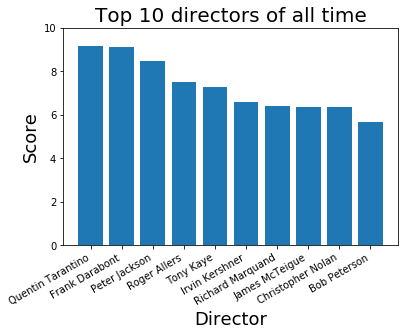